In [24]:
import numpy as np

# Step 1: Input 3x3 patch
I = np.array([
    [210, 208, 110],
    [208, 205, 106],
    [105, 102,  40]
], dtype=float)

# Step 2: Finite-difference gradients (no padding)
Ix = np.zeros_like(I, dtype=float)
Iy = np.zeros_like(I, dtype=float)

# Horizontal gradient (Ix)
Ix[:, 0] = I[:, 1] - I[:, 0]
Ix[:, 1] = (I[:, 2] - I[:, 0]) / 2
Ix[:, 2] = I[:, 2] - I[:, 1]

# Vertical gradient (Iy)
Iy[0, :] = I[1, :] - I[0, :]
Iy[1, :] = (I[2, :] - I[0, :]) / 2
Iy[2, :] = I[2, :] - I[1, :]

print("Ix:\n", Ix)
print("Iy:\n", Iy)

# Step 3: Element-wise products
Ixx = Ix ** 2
Iyy = Iy ** 2
Ixy = Ix * Iy

print("\nIxx:\n", Ixx)
print("Iyy:\n", Iyy)
print("Ixy:\n", Ixy)

# Step 4: Sum over window for Sxx, Syy, Sxy
Sxx = np.sum(Ixx)
Syy = np.sum(Iyy)
Sxy = np.sum(Ixy)

print("\nSxx:", Sxx)
print("Syy:", Syy)
print("Sxy:", Sxy)

# Step 5: Harris window matrix H
H = np.array([[Sxx, Sxy], [Sxy, Syy]])
print("\nH matrix:\n", H)

# Step 6: Eigenvalues and eigenvectors (closed-form for 2x2)
eigvals, eigvecs = np.linalg.eig(H)
idx = eigvals.argsort()
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("\nEigenvalues:", eigvals)
print("Eigenvectors:\n", eigvecs)

# Step 7: Harris response: R = det(H) - k * (trace(H))**2
k = 0.04
trH = np.trace(H)
detH = np.linalg.det(H)
R = detH - k * (trH ** 2)

print("\nHarris response R:", R)

# Step 8: Corner/edge/flat classification
tol = 0.6445
mag_thresh = 1e-2

if eigvals[0] > mag_thresh and eigvals[1] > mag_thresh:
    rel_diff = np.abs(eigvals[0] - eigvals[1]) / max(np.abs(eigvals[0]), np.abs(eigvals[1]))
    if rel_diff < tol:
        print("\nThe point is likely a Corner")
    else:
        print("\nThe point is likely a Edge")
elif eigvals[1] > mag_thresh:
    print("\nThe point is likely a Edge")
else:
    print("\nThe point is likely a Flat")


Ix:
 [[ -2.  -50.  -98. ]
 [ -3.  -51.  -99. ]
 [ -3.  -32.5 -62. ]]
Iy:
 [[  -2.    -3.    -4. ]
 [ -52.5  -53.   -35. ]
 [-103.  -103.   -66. ]]

Ixx:
 [[4.00000e+00 2.50000e+03 9.60400e+03]
 [9.00000e+00 2.60100e+03 9.80100e+03]
 [9.00000e+00 1.05625e+03 3.84400e+03]]
Iyy:
 [[4.00000e+00 9.00000e+00 1.60000e+01]
 [2.75625e+03 2.80900e+03 1.22500e+03]
 [1.06090e+04 1.06090e+04 4.35600e+03]]
Ixy:
 [[4.0000e+00 1.5000e+02 3.9200e+02]
 [1.5750e+02 2.7030e+03 3.4650e+03]
 [3.0900e+02 3.3475e+03 4.0920e+03]]

Sxx: 29428.25
Syy: 32393.25
Sxy: 14620.0

H matrix:
 [[29428.25 14620.  ]
 [14620.   32393.25]]

Eigenvalues: [16215.77785814 45605.72214186]
Eigenvectors:
 [[-0.74191807 -0.67049055]
 [ 0.67049055 -0.74191807]]

Harris response R: 586656344.8224994

The point is likely a Corner


In [14]:
# 2: Part A with Gaussian weighting window

# Gaussian window
W = (1/16) * np.array([[1, 2, 1],
                       [2, 4, 2],
                       [1, 2, 1]])

# Apply weighting to element-wise products
Sxx_w = np.sum(W * Ixx)
Syy_w = np.sum(W * Iyy)
Sxy_w = np.sum(W * Ixy)

H_w = np.array([[Sxx_w, Sxy_w],
                [Sxy_w, Syy_w]])
print("Weighted H matrix:\n", H_w)

eigvals_w, eigvecs_w = np.linalg.eig(H_w)
idx_w = eigvals_w.argsort()
eigvals_w = eigvals_w[idx_w]
eigvecs_w = eigvecs_w[:, idx_w]
print("Weighted Eigenvalues:", eigvals_w)
print("Weighted Eigenvectors:\n", eigvecs_w)

R_w = np.linalg.det(H_w) - k * (np.trace(H_w))**2
print("Weighted Harris response R:", R_w)


Weighted H matrix:
 [[3162.34375 1865.5625 ]
 [1865.5625  3463.71875]]
Weighted Eigenvalues: [1441.39288641 5184.66961359]
Weighted Eigenvectors:
 [[-0.73502075 -0.67804461]
 [ 0.67804461 -0.73502075]]
Weighted Harris response R: 5716957.729257821


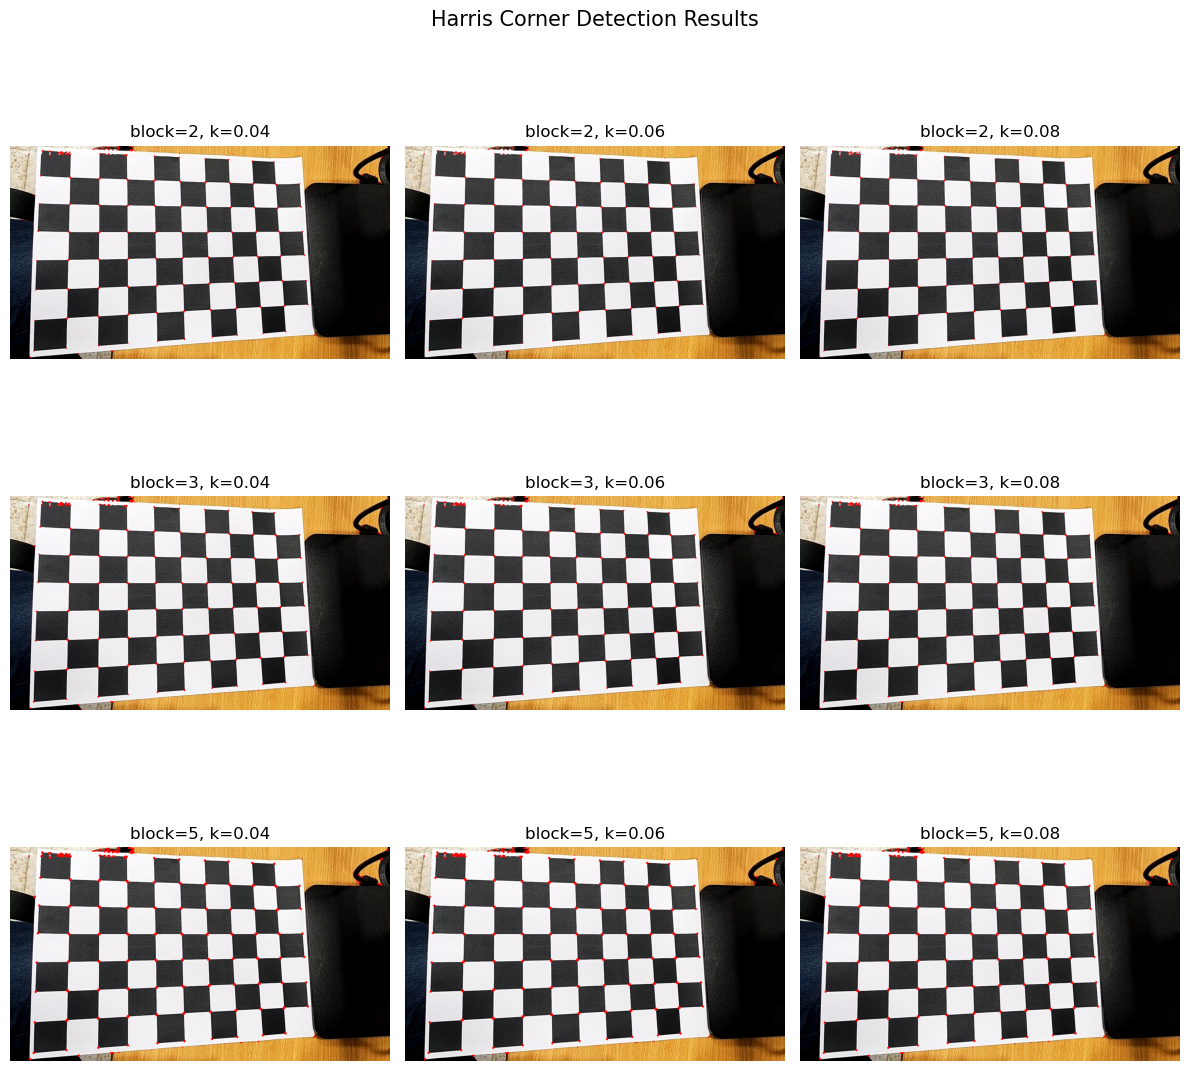

[(2, 3, 0.04),
 (2, 3, 0.06),
 (2, 3, 0.08),
 (3, 3, 0.04),
 (3, 3, 0.06),
 (3, 3, 0.08),
 (5, 3, 0.04),
 (5, 3, 0.06),
 (5, 3, 0.08)]

In [19]:
# 3: Part B - Harris on Image with Parameter Sweep, displaying in notebook

import cv2
import numpy as np
import matplotlib.pyplot as plt

def run_harris_inline(img_path, block_sizes, ksizes, ks, threshold_ratio=0.01):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    gray_blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    results = []
    fig, axarr = plt.subplots(len(block_sizes), len(ks), figsize=(4*len(ks), 4*len(block_sizes)))
    plt.suptitle("Harris Corner Detection Results", fontsize=15)
    
    for i, blockSize in enumerate(block_sizes):
        for j, k in enumerate(ks):
            for ksize in ksizes:
                dst = cv2.cornerHarris(gray_blur, blockSize=blockSize, ksize=ksize, k=k)
                dst_dilated = cv2.dilate(dst, None)
                thr = threshold_ratio * dst.max()
                vis = img_rgb.copy()
                vis[dst_dilated > thr] = [255, 0, 0]  # mark corners in blue (for visibility)
                
                ax = axarr[i, j] if len(block_sizes) > 1 else axarr[j]
                ax.imshow(vis)
                ax.set_title(f'block={blockSize}, k={k:.2f}')
                ax.axis('off')
                
                results.append((blockSize, ksize, k))
    
    plt.tight_layout()
    plt.show()
    return results


block_sizes = [2, 3, 5]
ksizes = [3]
ks = [0.04, 0.06, 0.08]
run_harris_inline('img_00.jpg', block_sizes, ksizes, ks)


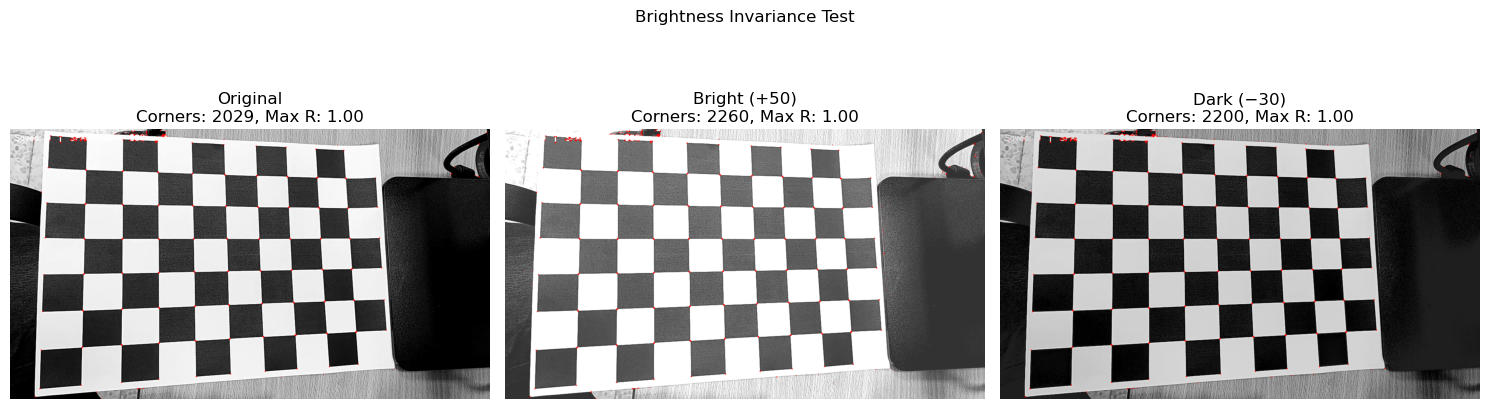

,Image,blockSize,k,ksize,Threshold,Corner Count,Max R
0,Original,3,0.04,3,0.01,2029,1.0
1,Bright (+50),3,0.04,3,0.01,2260,1.0
2,Dark (−30),3,0.04,3,0.01,2200,1.0


In [20]:
# 4: Part C - Brightness Invariance Test, display & results table

def brightness_invariance_test_inline(img_path, blockSize=3, ksize=3, k=0.04, threshold_ratio=0.01):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    bright = cv2.convertScaleAbs(gray, alpha=1.0, beta=50)   # Bright version
    dark = cv2.convertScaleAbs(gray, alpha=1.0, beta=-30)    # Dark version
    
    images = {'Original': gray, 'Bright (+50)': bright, 'Dark (−30)': dark}
    results = []
    
    fig, axarr = plt.subplots(1, 3, figsize=(15,5))
    plt.suptitle('Brightness Invariance Test')
    
    for i, (label, im) in enumerate(images.items()):
        dst = cv2.cornerHarris(im, blockSize=blockSize, ksize=ksize, k=k)
        dst_norm = dst / dst.max()
        thr = threshold_ratio
        if len(im.shape) == 2:
            im_color = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_GRAY2RGB)
        else:
            im_color = im.copy()
        vis = im_color.copy()
        vis[dst_norm > thr] = [255, 0, 0]
        count = np.sum(dst_norm > thr)
        max_r = dst_norm.max()
        axarr[i].imshow(vis)
        axarr[i].set_title(f"{label}\nCorners: {count}, Max R: {max_r:.2f}")
        axarr[i].axis('off')
        results.append((label, blockSize, k, ksize, thr, count, max_r))
    plt.tight_layout()
    plt.show()
    
    # Print result table
    import pandas as pd
    columns = ["Image", "blockSize", "k", "ksize", "Threshold", "Corner Count", "Max R"]
    df = pd.DataFrame(results, columns=columns)
    display(df)


brightness_invariance_test_inline('img_00.jpg')


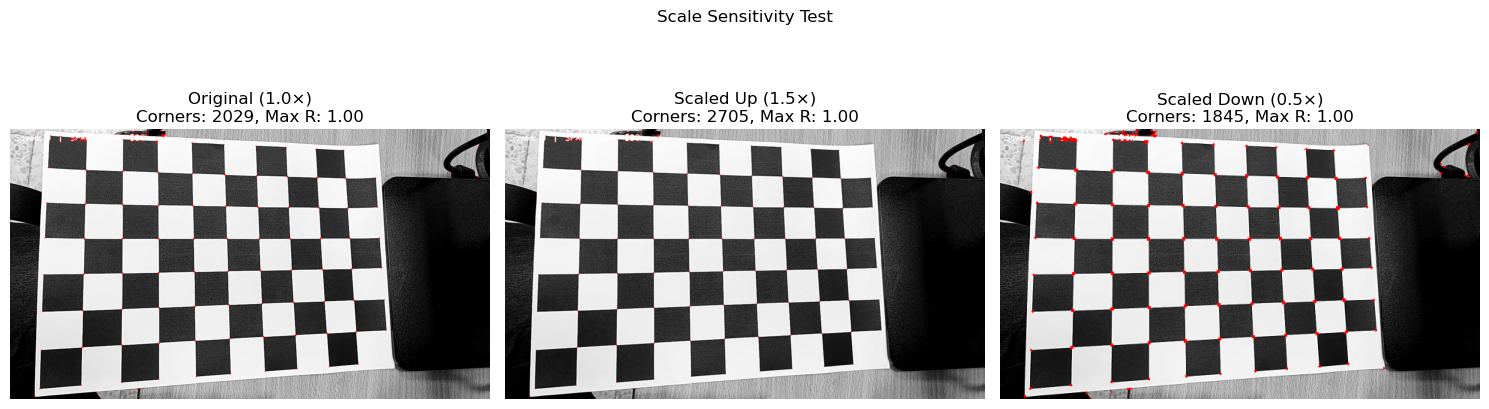

,Image,blockSize,k,ksize,Threshold,Corner Count,Max R
0,Original (1.0×),3,0.04,3,0.01,2029,1.0
1,Scaled Up (1.5×),3,0.04,3,0.01,2705,1.0
2,Scaled Down (0.5×),3,0.04,3,0.01,1845,1.0


In [21]:
# 5: Part D - Scale Sensitivity Test, display & results table

def scale_sensitivity_test_inline(img_path, blockSize=3, ksize=3, k=0.04, threshold_ratio=0.01):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    scaled_up = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    scaled_down = cv2.resize(gray, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    
    images = {'Original (1.0×)': gray, 'Scaled Up (1.5×)': scaled_up, 'Scaled Down (0.5×)': scaled_down}
    results = []
    
    fig, axarr = plt.subplots(1, 3, figsize=(15,5))
    plt.suptitle('Scale Sensitivity Test')
    
    for i, (label, im) in enumerate(images.items()):
        dst = cv2.cornerHarris(im, blockSize=blockSize, ksize=ksize, k=k)
        dst_norm = dst / dst.max()
        thr = threshold_ratio
        if len(im.shape) == 2:
            im_color = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_GRAY2RGB)
        else:
            im_color = im.copy()
        vis = im_color.copy()
        vis[dst_norm > thr] = [255, 0, 0]
        count = np.sum(dst_norm > thr)
        max_r = dst_norm.max()
        axarr[i].imshow(vis)
        axarr[i].set_title(f"{label}\nCorners: {count}, Max R: {max_r:.2f}")
        axarr[i].axis('off')
        results.append((label, blockSize, k, ksize, thr, count, max_r))
    plt.tight_layout()
    plt.show()
    
    # Print result table
    import pandas as pd
    columns = ["Image", "blockSize", "k", "ksize", "Threshold", "Corner Count", "Max R"]
    df = pd.DataFrame(results, columns=columns)
    display(df)

# Example usage:
scale_sensitivity_test_inline('img_00.jpg')
